## Lungs ROI Nodule Mask Extraction from LUNA16

In [1]:
# Source
# https://github.com/ayush9304/Lung_Cancer_Detection/blob/main/notebooks/v2/01_Lungs%20ROI%20_%20Nodule%20Mask%20extraction%20from%20LUNA16%20dataset.ipynb

%pip install numpy tqdm pandas opencv-python pydicom

^C
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/pip/__main__.py", line 19, in <module>
    sys.exit(_main())
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/usr/lib/python3/dist-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/usr/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 975, in _find_and_load

In [ ]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

In [ ]:
root = "/vol/bitbucket/bh1511/data/LUNA16/"
target_root = "./processed_data_raw/"

In [ ]:
subset = 9    # Ran for 0...9
file_list = glob(root+f"images/*.mhd")
annotations_df = pd.read_csv(root+"annotations.csv")
print("Files Count:",len(file_list))
print("DF Count:",len(annotations_df))
annotations_df.head()

Files Count: 884
DF Count: 1186


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


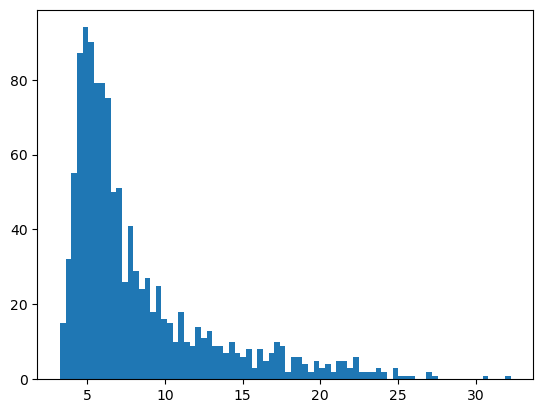

In [ ]:
d = annotations_df['diameter_mm'].values
fig = plt.hist(d, bins=80)

In [ ]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

annotations_df["filename"] = annotations_df["seriesuid"].map(lambda file: get_filename(file_list, file))
annotations_df = annotations_df.dropna()
annotations_df = annotations_df[annotations_df['diameter_mm']>=3.9]     # Excluding nodules with diameter less than 3.9mm
print(len(annotations_df))
annotations_df.head()

1149


,seriesuid,coordX,coordY,coordZ,diameter_mm,filename
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,/vol/bitbucket/bh1511/data/LUNA16/images/1.3.6...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,/vol/bitbucket/bh1511/data/LUNA16/images/1.3.6...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,/vol/bitbucket/bh1511/data/LUNA16/images/1.3.6...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,/vol/bitbucket/bh1511/data/LUNA16/images/1.3.6...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,/vol/bitbucket/bh1511/data/LUNA16/images/1.3.6...


In [ ]:
def load_mhd(file):
  mhdimage = stk.ReadImage(file)
  ct_scan = stk.GetArrayFromImage(mhdimage)
  origin = np.array(list(mhdimage.GetOrigin()))
  space = np.array(list(mhdimage.GetSpacing()))
  return ct_scan, origin, space

def make_mask(img, center, diam):
  mask = np.zeros_like(img, dtype=np.uint8)
  mask = cv2.circle(mask, (abs(int(center[0])),abs(int(center[1]))),int(abs(diam//2)), 255, -1)
  return mask

In [ ]:
n_neighbour = 4      # Number of neighbour slides to consider

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # CLAHE(Contrast Limited Adaptive Histogram Equalization) filter for enhancing the contrast of an image

# Iterating over all the files in the subset
for i,file in tqdm(enumerate(np.unique(annotations_df['filename'].values))):
    annotations = annotations_df[annotations_df["filename"]==file]
    ct, origin, space = load_mhd(file)      # Loading the CT scan
    num_z, height, width = ct.shape
    ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)   # Normalizing the CT scan
    for idx, row in annotations.iterrows():
        node_x = int(row["coordX"])     # X coordinate of the nodule
        node_y = int(row["coordY"])     # Y coordinate of the nodule
        node_z = int(row["coordZ"])     # Z coordinate of the nodule
        diam = int(row["diameter_mm"])  # Diameter of the nodule

        center = np.array([node_x, node_y, node_z])   # nodule center (x,y,z)
        v_center = np.rint((center-origin)/space)   # nodule center in voxel space (still x,y,z ordering)
        v_diam = int(diam/space[0])+5       # Diameter of the nodule in voxel space

        img_norm_neighbours = []
        img_norm_improved_neighbours = []
        mask_neighbours = []
        img_norm = None
        img_norm_improved = None
        mask = None

        if 18<v_diam<22:              # If nodule diameter is of medium size the take two neighbour slides into consideration
            n_neighbour = 2

        min_i = max(0,(int(v_center[2])-n_neighbour))
        max_i = min((int(v_center[2])+n_neighbour),(num_z-1))
        n = max_i-min_i
        
        img_norm = ct[int(v_center[2]),:,:]    # a slice of the CT scan containing the nodule
        img_norm = cv2.resize(img_norm, (512,512))  # Resizing the CT scan to 512x512
        img_norm_improved = clahe.apply(img_norm.astype(np.uint8))  # Applying CLAHE filter to the image
        mask = make_mask(img_norm, v_center, v_diam)    # Creating a mask of the nodule
        
        if v_diam>18:      # If the nodule is too big, we will also take neighboring slices
            for j in range(min_i, max_i+1):
                if j==int(v_center[2]):
                    continue

                im_n = ct[j,:,:]
                im_n = cv2.resize(im_n, (512,512))
                # im_n_improved = clahe.apply(im_n.astype(np.uint8))
                dia = int(2*abs(v_center[2]-j))    # Decrease mask diameter because nodule diameter decrease as we move away from its center
                msk = make_mask(im_n, v_center, v_diam-dia)
                img_norm_neighbours.append(im_n)
                img_norm_improved_neighbours.append(im_n)
                mask_neighbours.append(msk)
            assert len(img_norm_neighbours)==len(img_norm_improved_neighbours)==len(mask_neighbours)==n  

        # Calculating the threshold value for extracting the nodule mask using binary thresholding
        # mask = cv2.bitwise_and(img_norm, img_norm, mask=cv2.dilate(mask,kernel=np.ones((5,5))))
        # pts = mask[mask>0]
        # kmeans2 = KMeans(n_clusters=2).fit(np.reshape(pts,(len(pts),1)))
        # centroids2 = sorted(kmeans2.cluster_centers_.flatten())
        # threshold2 = np.mean(centroids2)
        
        # _, mask = cv2.threshold(mask, threshold2, 255, cv2.THRESH_BINARY)
        
        
        # if v_diam>18:
        #     for j in range(n):
        #         mask_neighbours[j] = cv2.bitwise_and(img_norm_neighbours[j], img_norm_neighbours[j], mask=cv2.dilate(mask_neighbours[j],kernel=np.ones((5,5))))
        #         _, mask_neighbours[j] = cv2.threshold(mask_neighbours[j], threshold2, 255, cv2.THRESH_BINARY)
        
        
        # Calculating the threshold value to segment the lungs from CT scan slices using binary thresholding
        # centeral_area = img_norm[100:400, 100:400]
        # kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
        # centroids = sorted(kmeans.cluster_centers_.flatten())
        # threshold = np.mean(centroids)
        
        # # Steps to segment the lungs from CT scan slices
        # ret, lung_roi = cv2.threshold(img_norm, threshold, 1000000, cv2.THRESH_BINARY_INV)
        # lung_roi = cv2.erode(img_norm, kernel=np.ones([4,4]))
        # lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))
        # lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))

        # labels = measure.label(img_norm)        # Labelling different regions in the image
        # regions = measure.regionprops(labels)   # Extracting the properties of the regions
        # good_labels = []
        # for prop in regions:        # Filtering the regions that are not too close to the edges
        #     B = prop.bbox           # Regions that are too close to the edges are outside regions of lungs
        #     if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
        #         good_labels.append(prop.label)
        # lung_roi_mask = np.zeros_like(labels)
        # for N in good_labels:
        #     lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

        # Steps to get proper segmentation of the lungs without noise and holes
        # contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        # external_contours = np.zeros(lung_roi_mask.shape)
        # for j in range(len(contours)):
        #     if hirearchy[0][j][3] == -1:  #External Contours
        #         area = cv2.contourArea(contours[j])
        #         if area>518.0:
        #             cv2.drawContours(external_contours,contours,j,(1,1,1),-1)
        # external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))
        
        # external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
        # external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
        # external_contours = cv2.bitwise_not(external_contours)
        # external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
        # external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))
        
        # img_norm_improved = img_norm_improved.astype(np.uint8)
        # external_contours = external_contours.astype(np.uint8)      # Final segmentated lungs mask
        # extracted_lungs = cv2.bitwise_and(img_norm_improved, img_norm_improved, mask=external_contours)
        
        mask = mask.astype(np.uint8)
        # np.save(os.path.join(target_root+"nodule_mask/", f"masks_{i}_{idx}.npy"), mask)
        np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{i}_{idx}.npy"), img_norm)
        
        extracted_lungs_neighbours = [None]*n
        
        if v_diam>18:
            for j in range(n):
                # img_norm_improved_neighbours[j] = img_norm_improved_neighbours[j].astype(np.uint8)
                # extracted_lungs_neighbours[j] = cv2.bitwise_and(img_norm_improved_neighbours[j], img_norm_improved_neighbours[j], mask=external_contours)
                mask_neighbours[j] = mask_neighbours[j].astype(np.uint8)
                # np.save(os.path.join(target_root+"nodule_mask/", f"masks_{i}_{idx}_{j}.npy"), mask_neighbours[j])
                np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{i}_{idx}_{j}.npy"), img_norm_improved_neighbours[j])

0it [00:00, ?it/s]


NameError: name 'external_contours' is not defined

In [ ]:
import shutil
from PIL import Image

dataset_path = "./luna16_raw/"
filenames = os.listdir(target_root+"lungs_roi/")

l = len(filenames)

# convert npy files to jpg files
for filename in filenames:
    if filename.endswith(".npy"):
        img_npy = np.load(os.path.join(target_root+"lungs_roi/", filename))
        img = Image.fromarray(img_npy).convert("L")
        img.save(os.path.join(target_root+"lungs_roi/", filename[:-4]+".jpg"))

print(l)

2217


In [ ]:
# move jpg files to the train and test folders
for filename in filenames[:int(l*0.8)]:  # 80% of the data for training
    if filename.endswith(".jpg"):
      shutil.copy(os.path.join(target_root+"lungs_roi/", filename), os.path.join(dataset_path+"train_imgs/", filename))

for filename in filenames[int(l*0.8):]:  # 20% of the data for testing
    if filename.endswith(".jpg"):
        shutil.copy(os.path.join(target_root+"lungs_roi/", filename), os.path.join(dataset_path+"test_imgs/", filename))